
Processing for N = 50 particles...
  Sampling initial conditions for N=50 using Metropolis-Hastings...


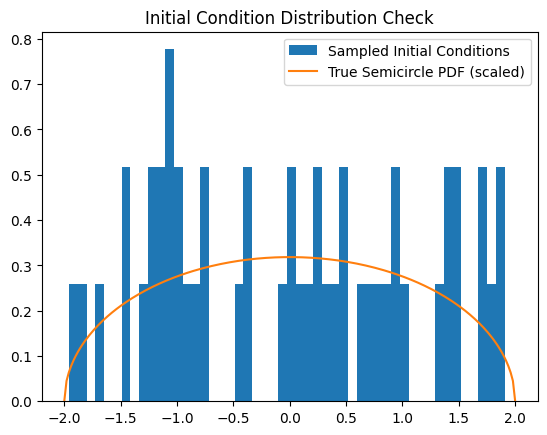

  Initial conditions sampled. Time: 0.27s
  beta = 0
    Calculating Reference Solution for N=50, beta=0...
    Ref Sol: Step 0/32768
    Ref Sol: Step 3276/32768
    Ref Sol: Step 6552/32768
    Ref Sol: Step 9828/32768
    Ref Sol: Step 13104/32768
    Ref Sol: Step 16380/32768
    Ref Sol: Step 19656/32768
    Ref Sol: Step 22932/32768
    Ref Sol: Step 26208/32768
    Ref Sol: Step 29484/32768
    Ref Sol: Step 32760/32768
    Reference solution calculated. Time: 39.75s
    tau = 0.00781 (K_RBM = 128 macro steps), N_RBM_AVG_RUNS=1
    RBM solutions calculated. Avg RBM Time: 0.02s/run
      N=50, beta=0, tau=0.00781, Avg_Error_E_hat=2.250e-02
    tau = 0.01562 (K_RBM = 64 macro steps), N_RBM_AVG_RUNS=1
    RBM solutions calculated. Avg RBM Time: 0.02s/run
      N=50, beta=0, tau=0.01562, Avg_Error_E_hat=4.168e-02
    tau = 0.03125 (K_RBM = 32 macro steps), N_RBM_AVG_RUNS=1
    RBM solutions calculated. Avg RBM Time: 0.00s/run
      N=50, beta=0, tau=0.03125, Avg_Error_E_hat=5.715e-0

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter # For tick formatting

# =======================================================
# --- Functions ---
# =======================================================

def semicircle_pdf(x, radius=2):
    """
    Probability density function (unnormalized) for Wigner semicircle.
    pdf(x) = sqrt(radius^2 - x^2) for |x| <= radius, 0 otherwise.
    The normalization constant is 1/(pi * radius^2 / 2), but M-H works with unnormalized.
    """
    if np.abs(x) <= radius:
        return np.sqrt(radius**2 - x**2) / (2*np.pi)
    else:
        return 0

def sample_initial_conditions_semicircle_metropolis_hastings(N, radius=2, steps=1000, burn_in=100, proposal_std=0.5):
    """
    Samples N initial conditions from the Wigner semicircle distribution
    using the Metropolis-Hastings algorithm.

    Parameters:
    N (int): Number of samples to generate.
    radius (float): Radius of the semicircle.
    steps (int): Number of M-H steps per sample (after burn-in).
    burn_in (int): Number of initial M-H steps to discard.
    proposal_std (float): Standard deviation for the normal proposal distribution.

    Returns:
    numpy.ndarray: Array of N samples.
    """
    X = np.zeros(N)
    x_current = 0  # Start at the center or a random point within [-radius, radius]

    # Burn-in phase
    for _ in range(burn_in):
        x_proposed = x_current + np.random.normal(0, proposal_std)
        if np.abs(x_proposed) > radius :
             pass # PDF will be 0, likely rejected if x_current is valid

        acceptance_ratio = 0
        pdf_current = semicircle_pdf(x_current, radius)
        if pdf_current > 0: # Avoid division by zero if x_current somehow became invalid
            pdf_proposed = semicircle_pdf(x_proposed, radius)
            acceptance_ratio = pdf_proposed / pdf_current
        
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed

    # Sampling phase
    for i in range(N):
        for _ in range(steps): # Run M-H for a few steps to get less correlated samples
            x_proposed = x_current + np.random.normal(0, proposal_std)

            acceptance_ratio = 0
            pdf_current = semicircle_pdf(x_current, radius)
            if pdf_current > 0:
                pdf_proposed = semicircle_pdf(x_proposed, radius)
                acceptance_ratio = pdf_proposed / pdf_current

            if np.random.rand() < acceptance_ratio:
                x_current = x_proposed
        X[i] = x_current
        
    # Optional: Check distribution if N is large

    plt.hist(X, bins=50, density=True, label='Sampled Initial Conditions')
    x_vals = np.linspace(-radius, radius, 200)
    y_vals = [semicircle_pdf(x, radius) for x in x_vals]
    plt.plot(x_vals, y_vals, label='True Semicircle PDF (scaled)')
    plt.legend()
    plt.title("Initial Condition Distribution Check")
    plt.show()
        
    return X

def solve_fully_coupled_system_euler(X0, beta, T, K, verbose=False): # Added verbose
    """
    Solves the fully coupled N-particle system using Forward Euler.
    dX_i = -beta * X_i dt + (1/(N-1)) * sum_{j!=i} K(Xi,Xj) dt + sigma dW
    """
    N = len(X0)
    X_ref = np.copy(X0)
    tau = T / K

    for k_step in range(K):
        X_new = np.zeros_like(X_ref) # Store updates for simultaneous update
        
        # Pre-calculate all interactions for efficiency if N is large,
        for i in range(N):
            interaction_force = 0
            for j in range(N):
                if i == j:
                    continue
                diff = X_ref[i] - X_ref[j]
                interaction_force += diff / (1.0 + diff**2)

            drift = -beta * X_ref[i] + (1.0 / (N - 1.0)) * interaction_force
            X_new[i] = X_ref[i] + drift * tau
        X_ref = X_new # Simultaneous update
        if verbose and k_step % (K // 10) == 0 and K >=10 :
             print(f"    Ref Sol: Step {k_step}/{K}")
    return X_ref


def solve_rbm1_euler(X0, beta, T, p, K, verbose=False): # Added verbose
    """
    Solves the system using RBM-1. Each macro RBM step is one Euler step of size tau.
    """
    N = len(X0)
    X_rbm = np.copy(X0)
    tau = T / K

    for m in range(K):
        indices = np.random.permutation(N)
        
        # Store updates for this macro step to apply simultaneously if desired,
        # but sequential updates within a macro step for different batches is standard.
        # Particles are updated based on values from the *beginning* of the macro step's batches.
        X = np.copy(X_rbm) # Work on a copy for this macro step's drift calcs

        for i in range(0, N, p):
            batch_indices = indices[i : i + p]
            
            # If the last batch is smaller than p
            batch_p = len(batch_indices)
            if batch_p <=1 and N > 1: # single particle left over
                if batch_p == 1:
                    idx = batch_indices[0]
                    X_new = X_rbm[idx] # Value from start of macro step
                    drift = -beta * X_new # No interaction
                    X[idx] = X_new + drift * tau
                continue # Move to next batch if any

            # Calculate drift for particles in this batch based on X_rbm (values at start of macro step)
            batch_drifts = np.zeros(batch_p)
            X_batch = X_rbm[batch_indices]

            for i_idx, i in enumerate(batch_indices):
                current_drift = X_batch[i_idx]
                interaction_force = 0
                num_others = 0
                for j_idx, j in enumerate(batch_indices):
                    if i != j:
                        other_drift = X_batch[j_idx]
                        diff = current_drift - other_drift
                        interaction_force += diff / (1 + diff**2)
                        num_others += 1
                
                interaction_term = 0
                # Divisor is (p-1), i.e. num_others
                if num_others > 0:
                    interaction_term = (1 / num_others) * interaction_force
                
                batch_drifts[i_idx] = -beta * current_drift + interaction_term

            # Update particles in the batch using calculated drifts
            # These updates use X_rbm (values from *start* of macro step m) to calculate drift
            # then apply to X
            for i_idx, i in enumerate(batch_indices):
                X[i] = X_batch[i_idx] + batch_drifts[i_idx] * tau
        X_rbm = X # All particles updated for this macro step

        if verbose and m % (K // 10) == 0 and K >= 10:
            print(f"    RBM Sol: Macro Step {m}/{K}")
            
    return X_rbm

def calculate_rbm_error(X_rbm, X_ref):
    if len(X_rbm) != len(X_ref):
        raise ValueError("RBM and Reference solutions must have the same number of particles.")
    if len(X_rbm) == 0:
        return 0
    error_sq_sum = np.sum((X_rbm - X_ref)**2)
    return np.sqrt(error_sq_sum / len(X_rbm))


# =======================================================
# --- Parameters ---
# =======================================================
T = 1
N_values = [50]

p = 2
beta_values = [0, 1]

tau_powers = [-7, -6, -5, -4]
tau_values = [2**pow for pow in tau_powers]

K = 2**15
radius = 2.0

# Metropolis-Hastings parameters for initial condition sampling
steps = 20 # Number of M-H steps to take for each particle after burn-in
burn_in = 500       # Initial M-H steps to discard
proposal_std = 0.8  # Proposal step size for M-H

# Averaging RBM Error
N_RBM_AVERAGE_RUNS = 1 # Number of RBM runs to average error over for smoother plots
                        # Paper doesn't specify, but plots are smooth. Use 1 for quickest test.
                        # If N_RBM_AVERAGE_RUNS = 1, it's one realization of shuffling.


# =======================================================
# --- Main Simulation Loop ---
# =======================================================
figure2_results = []
simulation_start_time = time.time()
np.random.seed(42) # For reproducibility of M-H and shuffles if N_RBM_AVERAGE_RUNS = 1

print_ref_progress = True # Control verbosity for reference solution calculation

for N in N_values:
    print(f"\nProcessing for N = {N} particles...")
    
    print(f"  Sampling initial conditions for N={N} using Metropolis-Hastings...")
    init_cond_time_start = time.time()
    X0 = sample_initial_conditions_semicircle_metropolis_hastings(
        N, radius, steps, burn_in, proposal_std
    )
    init_cond_time_end = time.time()
    print(f"  Initial conditions sampled. Time: {init_cond_time_end - init_cond_time_start:.2f}s")
    
    for beta in beta_values:
        print(f"  beta = {beta}")
        
        print(f"    Calculating Reference Solution for N={N}, beta={beta}...")
        ref_start_time = time.time()
        X_ref = solve_fully_coupled_system_euler(
            X0, beta, T, K, verbose=print_ref_progress
        )
        ref_end_time = time.time()
        print(f"    Reference solution calculated. Time: {ref_end_time - ref_start_time:.2f}s")

        for tau in tau_values:
            K_rbm = int(round(T / tau)) # Use round for robustness
            print(f"    tau = {tau:.5f} (K_RBM = {K_rbm} macro steps), N_RBM_AVG_RUNS={N_RBM_AVERAGE_RUNS}")
            
            errors = np.zeros(N_RBM_AVERAGE_RUNS)
            rbm_time = 0
            
            for rbm_run_idx in range(N_RBM_AVERAGE_RUNS):
                # print(f"      RBM Avg Run {rbm_run_idx+1}/{N_RBM_AVERAGE_RUNS}...")
                # RBM starts from the SAME X0 for each of these averaging runs
                # but the shuffling will be different each time.
                rbm_start_time = time.time()
                X_rbm = solve_rbm1_euler(
                    X0, beta, T, p, K_rbm, verbose=False # Less verbose for inner RBM runs
                )
                rbm_end_time = time.time()
                rbm_time += (rbm_end_time - rbm_start_time)
                errors[rbm_run_idx] = calculate_rbm_error(X_rbm, X_ref)

            avg_error = np.mean(errors)
            avg_rbm_time = rbm_time / N_RBM_AVERAGE_RUNS
            print(f"    RBM solutions calculated. Avg RBM Time: {avg_rbm_time:.2f}s/run")
            
            figure2_results.append({
                "N": N,
                "beta": beta,
                "tau": tau,
                "Error_E_hat": avg_error
            })
            print(f"      N={N}, beta={beta}, tau={tau:.5f}, Avg_Error_E_hat={avg_error:.3e}")

simulation_end_time = time.time()
print(f"\nTotal simulation time: {simulation_end_time - simulation_start_time:.2f} seconds.")




In [2]:
# =======================================================
# --- Display Results ---
# =======================================================
df_fig2_results = pd.DataFrame(figure2_results)
print("\n--- Results for Figure 2 Data Points (Averaged RBM Error) ---")
# Format for better readability
df_print_fig2 = df_fig2_results.copy()
df_print_fig2["tau"] = df_print_fig2["tau"].map('{:.5f}'.format)
df_print_fig2["Error_E_hat"] = df_print_fig2["Error_E_hat"].map('{:.3e}'.format)
print(df_print_fig2.to_string(index=False))


--- Results for Figure 2 Data Points (Averaged RBM Error) ---
 N  beta     tau Error_E_hat
50     0 0.00781   2.250e-02
50     0 0.01562   4.168e-02
50     0 0.03125   5.715e-02
50     0 0.06250   9.166e-02
50     1 0.00781   1.862e-02
50     1 0.01562   2.755e-02
50     1 0.03125   3.747e-02
50     1 0.06250   5.757e-02


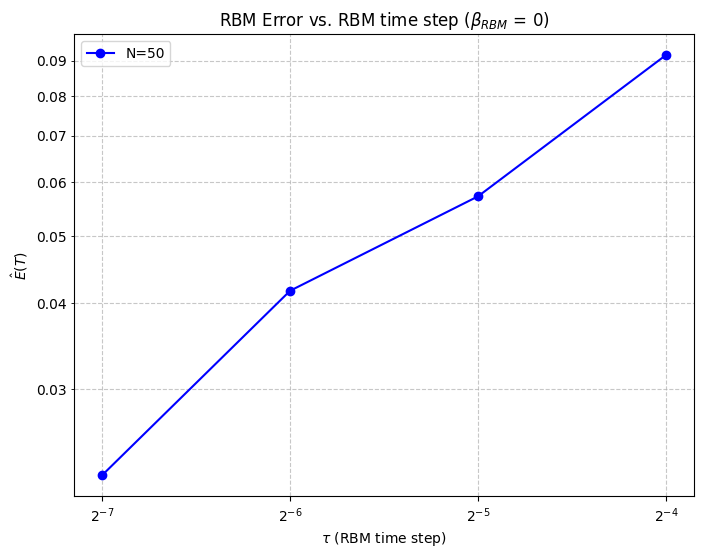

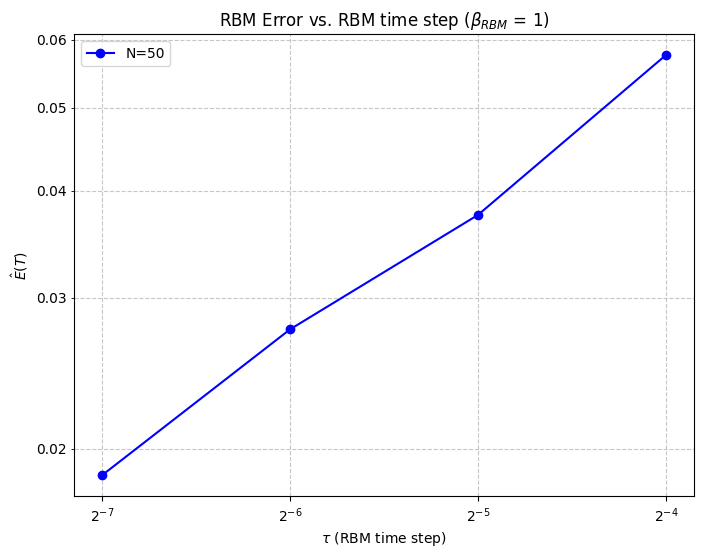

In [3]:
# =======================================================
# --- Plotting Figure 2 ---
# =======================================================
run_figure2 = True # Set to False to skip

if run_figure2:
    for b in df_fig2_results["beta"].unique():
        plt.figure(figsize=(8, 6))
        plot_beta = df_fig2_results[df_fig2_results["beta"] == b]
        
        # Define markers and colors as in the paper (approximate)
        markers = ['o', '*', 's'] # circle, star, square
        colors = ['blue', 'black', 'red'] # As per Fig 2 caption: N=50 blue circle, N=500 black star, N=2000 red square

        sorted_N = sorted(plot_beta["N"].unique())

        for i, n in enumerate(sorted_N):
            plot_N = plot_beta[plot_beta["N"] == n]
            # Sort by tau for consistent plotting lines
            plot_N = plot_N.sort_values(by="tau")
            plt.plot(plot_N["tau"], plot_N["Error_E_hat"], 
                     marker=markers[i % len(markers)], 
                     color=colors[i % len(colors)],
                     linestyle='-', 
                     label=f'N={n}')
        
        plt.xscale('log', base=2)
        plt.yscale('log')
        plt.xlabel(r'$\tau$ (RBM time step)') # Using tau as in paper's Fig 2
        plt.ylabel(r'$\hat{E}(T)$')
        plt.title(f'RBM Error vs. RBM time step ($\\beta_{{RBM}}$ = {b})')
        plt.legend()
        plt.grid(True, which="both", ls="--", alpha=0.7)
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places
        plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2f")) # 2 decimal places for minor ticks
      
        sorted_tau = sorted(list(df_fig2_results["tau"].unique()))
        xtick_labels_powers = [int(np.log2(val)) for val in sorted_tau]
        xtick_labels = [f'$2^{{{pow}}}$' for pow in xtick_labels_powers]
        plt.xticks(sorted_tau, xtick_labels)
        plt.show()






=== GENERATING DATA FOR FIGURE 3: Error vs. Time T ===


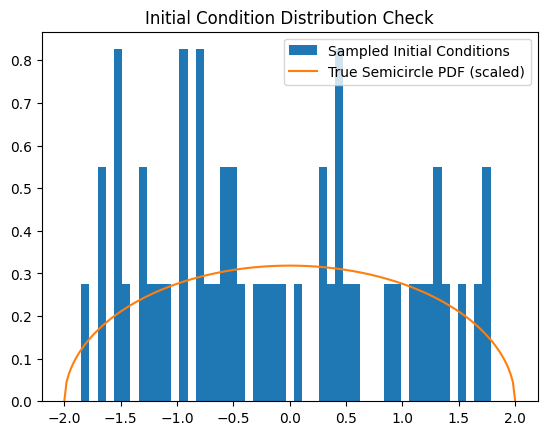


Fig3: N = 50, beta_RBM = 0.0
    Fig3: T_final = 1.00 (K_ref=32768, K_RBM=128), AvgRuns=1
    Ref Sol: Step 0/32768
    Ref Sol: Step 3276/32768
    Ref Sol: Step 6552/32768
    Ref Sol: Step 9828/32768
    Ref Sol: Step 13104/32768
    Ref Sol: Step 16380/32768
    Ref Sol: Step 19656/32768
    Ref Sol: Step 22932/32768
    Ref Sol: Step 26208/32768
    Ref Sol: Step 29484/32768
    Ref Sol: Step 32760/32768
      Fig3: Avg_Error_E_hat=3.516e-02
    Fig3: T_final = 2.00 (K_ref=65536, K_RBM=256), AvgRuns=1
    Ref Sol: Step 0/65536
    Ref Sol: Step 6553/65536
    Ref Sol: Step 13106/65536
    Ref Sol: Step 19659/65536
    Ref Sol: Step 26212/65536
    Ref Sol: Step 32765/65536
    Ref Sol: Step 39318/65536
    Ref Sol: Step 45871/65536
    Ref Sol: Step 52424/65536
    Ref Sol: Step 58977/65536
    Ref Sol: Step 65530/65536
      Fig3: Avg_Error_E_hat=4.774e-02
    Fig3: T_final = 4.00 (K_ref=131072, K_RBM=512), AvgRuns=1
    Ref Sol: Step 0/131072
    Ref Sol: Step 13107/131072
    

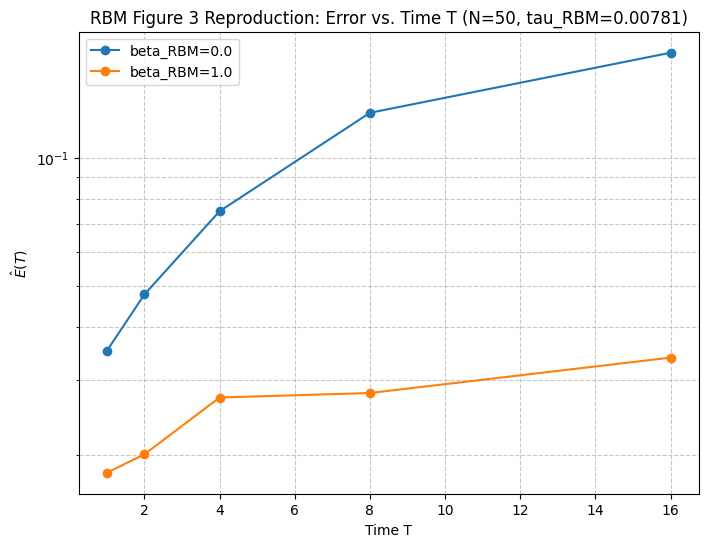

In [7]:
# =======================================================
# --- Plotting Figure 3 ---
# =======================================================
run_figure3 = True # Set to False to skip
verbose_figure3 = True

if run_figure3:
    print("\n\n=== GENERATING DATA FOR FIGURE 3: Error vs. Time T ===")
    N_fig3 = 50 # Fixed N as per RBM paper Fig 3
    beta_values_fig3 = [0.0, 1.0] # Two lines in Fig 3
    tau_rbm_fig3 = 2**-7 # Fixed RBM time step
    T_values_fig3 = [1, 2, 4, 8, 16] # As per RBM paper's x-axis for Fig 3
    
    K_ref_fig3_base = 2**15 # Micro steps for reference solution at T=1
                            # For larger T, might need to scale K_ref, or accept longer runs
                            # Let's keep K_ref fixed, meaning h_micro scales with T
                            # Or, better, scale K_ref_fig3 to keep h_micro_fig3 constant
    h_micro_target_fig3 = 1.0 / (2**15) # Target micro step size (same as for T=1 ref)


    figure3_results_list = []
    fig3_total_start_time = time.time()

    X0_fig3 = sample_initial_conditions_semicircle_metropolis_hastings(
        N_fig3, radius, steps, burn_in, proposal_std
    )

    for beta_fig3 in beta_values_fig3:
        if verbose_figure3: print(f"\nFig3: N = {N_fig3}, beta_RBM = {beta_fig3}")
        for T_fig3_current in T_values_fig3:
            if T_fig3_current == 0: # Error is 0 at T=0
                avg_error_fig3 = 0.0
                if verbose_figure3: print(f"    Fig3: T_final = {T_fig3_current:.2f}, Avg_Error_E_hat={avg_error_fig3:.3e}")
                figure3_results_list.append({
                    "N": N_fig3, "beta_RBM": beta_fig3, "T_final": T_fig3_current, "Error_E_hat": avg_error_fig3
                })
                continue

            K_ref_current_fig3 = int(round(T_fig3_current / h_micro_target_fig3))
            K_rbm_current_fig3 = int(round(T_fig3_current / tau_rbm_fig3))
            
            if verbose_figure3: print(f"    Fig3: T_final = {T_fig3_current:.2f} (K_ref={K_ref_current_fig3}, K_RBM={K_rbm_current_fig3}), AvgRuns={N_RBM_AVERAGE_RUNS}")

            X_ref_fig3 = solve_fully_coupled_system_euler(
                X0_fig3, beta_fig3, T_fig3_current, K_ref_current_fig3, verbose=(K_ref_current_fig3 > 10000)
            )
            
            errors_current_T = np.zeros(N_RBM_AVERAGE_RUNS)
            for rbm_run_idx in range(N_RBM_AVERAGE_RUNS):
                X_rbm_fig3 = solve_rbm1_euler(
                    X0_fig3, beta_fig3, T_fig3_current, p, K_rbm_current_fig3, verbose=False
                )
                errors_current_T[rbm_run_idx] = calculate_rbm_error(X_rbm_fig3, X_ref_fig3)
            avg_error_fig3 = np.mean(errors_current_T)
            
            figure3_results_list.append({
                "N": N_fig3, "beta_RBM": beta_fig3, "T_final": T_fig3_current, "Error_E_hat": avg_error_fig3
            })
            if verbose_figure3: print(f"      Fig3: Avg_Error_E_hat={avg_error_fig3:.3e}")

    df_fig3_results = pd.DataFrame(figure3_results_list)
    print("\n--- Fig3 Results (Error vs. Time T) ---")
    print(df_fig3_results.to_string(index=False))
    fig3_total_end_time = time.time()
    if verbose_figure3: print(f"Fig3 Total Time: {fig3_total_end_time - fig3_total_start_time:.2f}s")
    
    # Plotting for Figure 3
    plt.figure(figsize=(8, 6))
    for beta_val_plot in df_fig3_results["beta_RBM"].unique():
        subset_beta = df_fig3_results[df_fig3_results["beta_RBM"] == beta_val_plot]
        plt.plot(subset_beta["T_final"], subset_beta["Error_E_hat"], marker='o', linestyle='-', label=f'beta_RBM={beta_val_plot}')
    plt.xlabel('Time T')
    plt.ylabel(r'$\hat{E}(T)$')
    plt.title(f'RBM Figure 3 Reproduction: Error vs. Time T (N={N_fig3}, tau_RBM={tau_rbm_fig3:.5f})')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.yscale('log') # Error often plotted on log scale
    plt.savefig("rbm_fig3_error_vs_time.png")
    plt.show()



=== GENERATING DATA FOR FIGURE 4: Error vs. CPU Time ===


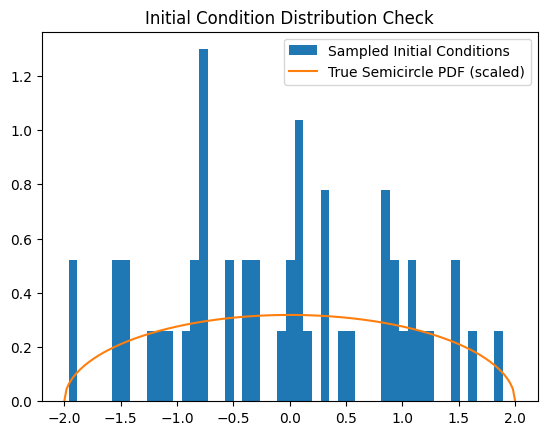


Fig4: Calculating High-Accuracy Reference Solution (N=50, K_ref=32768)...
    Ref Sol: Step 0/32768
    Ref Sol: Step 3276/32768
    Ref Sol: Step 6552/32768
    Ref Sol: Step 9828/32768
    Ref Sol: Step 13104/32768
    Ref Sol: Step 16380/32768
    Ref Sol: Step 19656/32768
    Ref Sol: Step 22932/32768
    Ref Sol: Step 26208/32768
    Ref Sol: Step 29484/32768
    Ref Sol: Step 32760/32768
Fig4: High-Accuracy Reference Done. Time: 42.39s

Fig4: Generating data for Direct Computation line...
  Fig4 Direct: K_micro_steps = 64 (h_micro=1.56e-02)
    Direct: CPU=0.088s, Error=2.142e-03
  Fig4 Direct: K_micro_steps = 128 (h_micro=7.81e-03)
    Direct: CPU=0.154s, Error=1.065e-03
  Fig4 Direct: K_micro_steps = 256 (h_micro=3.91e-03)
    Direct: CPU=0.287s, Error=5.296e-04
  Fig4 Direct: K_micro_steps = 512 (h_micro=1.95e-03)
    Direct: CPU=0.618s, Error=2.625e-04
  Fig4 Direct: K_micro_steps = 1024 (h_micro=9.77e-04)
    Direct: CPU=1.225s, Error=1.291e-04

Fig4: Generating data for RB

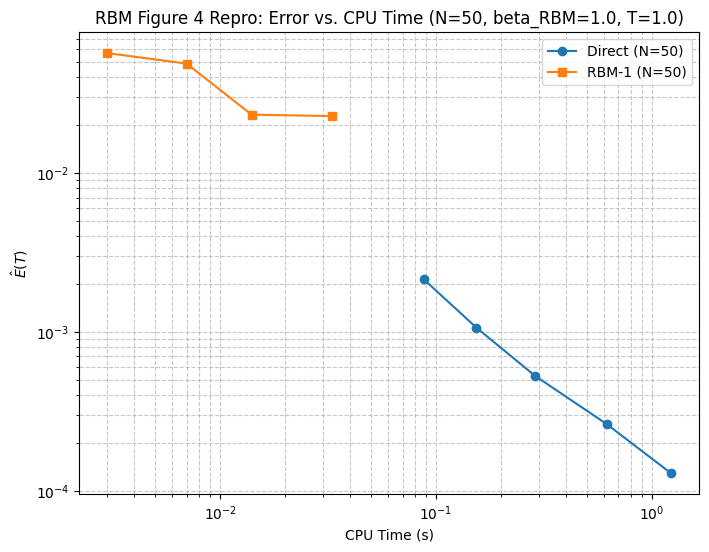

In [9]:
# =======================================================
# --- Plotting Figure 4 ---
# =======================================================
run_figure4 = True # Set to False to skip
verbose_figure4 = True

if run_figure4:
    print("\n\n=== GENERATING DATA FOR FIGURE 4: Error vs. CPU Time ===")
    # Parameters based on RBM paper Fig 4 (often N=1000, beta=1, T=1)
    N_fig4 = 50 
    # N_fig4 = 100 # For faster test run
    beta_fig4 = 1.0
    T_final_fig4 = 1.0
    
    # High-accuracy reference for comparing both methods
    K_ref_high_accuracy_fig4 = 2**15 
    # K_ref_high_accuracy_fig4 = 2**12 # Faster ref for quicker fig4 test
    
    figure4_results_list = []
    fig4_total_start_time = time.time()

    X0_fig4 = sample_initial_conditions_semicircle_metropolis_hastings(
        N_fig4, radius, steps, burn_in, proposal_std
    )
    
    if verbose_figure4: print(f"\nFig4: Calculating High-Accuracy Reference Solution (N={N_fig4}, K_ref={K_ref_high_accuracy_fig4})...")
    ref_acc_start_time = time.time()
    X_REF_FOR_FIG4 = solve_fully_coupled_system_euler(
        X0_fig4, beta_fig4, T_final_fig4, K_ref_high_accuracy_fig4, verbose=(K_ref_high_accuracy_fig4 > 10000)
    )
    ref_acc_end_time = time.time()
    if verbose_figure4: print(f"Fig4: High-Accuracy Reference Done. Time: {ref_acc_end_time - ref_acc_start_time:.2f}s")

    # 1. Data for "Direct Computation" (Fully Coupled Euler)
    if verbose_figure4: print("\nFig4: Generating data for Direct Computation line...")
    # K_direct_powers = list(range(6, 13)) # 2^6 to 2^12 for K_micro_steps_direct
    K_direct_powers = list(range(6, 11)) # Smaller range for speed: 2^6 (64) to 2^10 (1024)
    K_direct_values_fig4 = [2**pow_val for pow_val in K_direct_powers]

    for K_direct in K_direct_values_fig4:
        h_micro_direct = T_final_fig4 / K_direct
        if verbose_figure4: print(f"  Fig4 Direct: K_micro_steps = {K_direct} (h_micro={h_micro_direct:.2e})")
        
        direct_start_time = time.time()
        X_direct = solve_fully_coupled_system_euler(
            X0_fig4, beta_fig4, T_final_fig4, K_direct, verbose=False
        )
        direct_end_time = time.time()
        cpu_time_direct = direct_end_time - direct_start_time
        error_direct = calculate_rbm_error(X_direct, X_REF_FOR_FIG4)
        
        figure4_results_list.append({
            "Method": "Direct", "N": N_fig4, "beta_RBM": beta_fig4, 
            "Steps_or_Tau": K_direct, # Storing K_micro_steps here
            "CPU_Time_s": cpu_time_direct, "Error_E_hat": error_direct
        })
        if verbose_figure4: print(f"    Direct: CPU={cpu_time_direct:.3f}s, Error={error_direct:.3e}")

    # 2. Data for "RBM-1"
    if verbose_figure4: print("\nFig4: Generating data for RBM-1 line...")
    # tau_rbm_powers_fig4 = list(range(-8, -2)) # 2^-8 to 2^-3 for tau_RBM
    tau_rbm_powers_fig4 = list(range(-7, -3)) # Smaller range: 2^-7 to 2^-4
    tau_rbm_values_fig4 = [2**pow_val for pow_val in tau_rbm_powers_fig4]

    for tau_rbm_fig4 in tau_rbm_values_fig4:
        K_rbm_fig4 = int(round(T_final_fig4 / tau_rbm_fig4))
        if verbose_figure4: print(f"  Fig4 RBM: tau_RBM = {tau_rbm_fig4:.5f} (K_RBM = {K_rbm_fig4}), AvgRuns={N_RBM_AVERAGE_RUNS}")

        errors_current_tau_fig4 = np.zeros(N_RBM_AVERAGE_RUNS)
        cpu_times_current_tau_fig4 = np.zeros(N_RBM_AVERAGE_RUNS)

        for rbm_run_idx in range(N_RBM_AVERAGE_RUNS):
            rbm_start_time = time.time()
            X_rbm_fig4 = solve_rbm1_euler(
                X0_fig4, beta_fig4, T_final_fig4, p, K_rbm_fig4, verbose=False
            )
            rbm_end_time = time.time()
            cpu_times_current_tau_fig4[rbm_run_idx] = rbm_end_time - rbm_start_time
            errors_current_tau_fig4[rbm_run_idx] = calculate_rbm_error(X_rbm_fig4, X_REF_FOR_FIG4)
        
        avg_error_fig4 = np.mean(errors_current_tau_fig4)
        avg_cpu_time_fig4 = np.mean(cpu_times_current_tau_fig4)
        
        figure4_results_list.append({
            "Method": "RBM-1", "N": N_fig4, "beta_RBM": beta_fig4,
            "Steps_or_Tau": tau_rbm_fig4, # Storing tau_RBM here
            "CPU_Time_s": avg_cpu_time_fig4, "Error_E_hat": avg_error_fig4
        })
        if verbose_figure4: print(f"    RBM: CPU={avg_cpu_time_fig4:.3f}s, Error={avg_error_fig4:.3e}")

    df_fig4_results = pd.DataFrame(figure4_results_list)
    print("\n--- Fig4 Results (Error vs. CPU Time) ---")
    print(df_fig4_results.to_string(index=False))
    fig4_total_end_time = time.time()
    if verbose_figure4: print(f"Fig4 Total Time: {fig4_total_end_time - fig4_total_start_time:.2f}s")

    # Plotting for Figure 4
    plt.figure(figsize=(8, 6))
    methods = df_fig4_results["Method"].unique()
    markers_fig4 = ['o', 's', '^'] # Different markers for different methods/N values

    for i, method in enumerate(methods):
        subset_method = df_fig4_results[df_fig4_results["Method"] == method]
        # Sort by CPU_Time_s for consistent plotting lines
        subset_method = subset_method.sort_values(by="CPU_Time_s")
        plt.plot(subset_method["CPU_Time_s"], subset_method["Error_E_hat"], 
                 marker=markers_fig4[i % len(markers_fig4)], 
                 linestyle='-', 
                 label=f'{method} (N={N_fig4})')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('CPU Time (s)')
    plt.ylabel(r'$\hat{E}(T)$')
    plt.title(f'RBM Figure 4 Repro: Error vs. CPU Time (N={N_fig4}, beta_RBM={beta_fig4}, T={T_final_fig4})')
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.7)
    plt.savefig(f"rbm_fig4_error_vs_cputime_N{N_fig4}.png")
    plt.show()